<a href="https://colab.research.google.com/github/shinjeongdong/MLDeeplearningStudy/blob/main/%EB%B0%91%EB%B0%94%EB%8B%A5%EB%94%A5%EB%9F%AC%EB%8B%9D/%EB%B0%91%EB%B0%94%EB%8B%A5_%EB%94%A5%EB%9F%AC%EB%8B%9D_6%EC%9E%A5_%ED%95%99%EC%8A%B5%EA%B4%80%EB%A0%A8%EA%B8%B0%EC%88%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import importlib
import matplotlib.pyplot as plt
import sys
import pickle
import copy

importlib.invalidate_caches()
sys.path.append('/content/drive/MyDrive/dataset')
from func import softmax,cross_entropy_error

In [ ]:
#6.1 매개변수 갱신
#신경망의 목표는 손실함수의 값을 최대한 낮추는 매개변수를 찾는게 목표였는데
#이런 행동을 최적화라고 한다. 우리는 지금까지 매개변수를 찾는데 미니 배치 확률적 경사하강법이란 방법을 사용하였는데
#이 것보다 더 좋은 방법을 알아보자.
#경사하강법 모든 loss를 고려해서 업데이트가 너무 신중함 로컬 미니멈, 안장점에서 탈출이 불가.
#확률적 경사하강법 하나의 loss만 고려해서 업데이트
#미니배치 확률적 경사하강법 자기가 정한 개수의 loss만 고려해서 업데이트함.

In [ ]:
#SGD
# W <- W - n(∂L/∂W) # W는 갱신해야할 가중치 n은 학습률 ∂L/∂W은 손실함수의 기울기

class SGD:
  def __init__(self,lr= 0.01):
    self.lr = lr

  def update(self,params,grads):
    for key in params.key():
      params[key] -= self.lr * grads[key]


In [ ]:
#momentum
#v <- m * v - an(∂L/∂W)
# W <- W + v
#v라는 새로운 변수가 나오는데 이는 물리에서 말하는 속도인 velocity임
#모멘텀은 공이 그릇의 바닥을 구르는 듯한 움직임을 보여줌 = 관성
#a는 모멘텀 계수라고함 = 0.9

class Momentum:
  def __init__(self, lr=0.01, momentum = 0.9):
    self.lr = lr
    self.momentum = momentum
    self.v = None

  def update(self,params,grads):
    if self.v is None: #v 초기화
      self.v = {}
      for key, val in params.items():  #items함수는 딕셔너리의 키와 벨류값을 리턴해준다. key = "W1", dict = np.array([[1,2,3],[4,5,6]])
        self.v[key] = np.zeros_like(val) # 결국은 v['W1'] = np.array([[0,0,0],[0,0,0]])가 됨 W1의 모양과 같게 0으로 초기화함

    for key in params.keys():
      self.v[key] = self.momentum * self.v[key] - self.lr * grads[key] #정리하면 v['W1'] = 0.9 * v['W1'] - lr * gd['W1']으로 됨
      params[key] += self.v[key]

In [ ]:
#RMSprop 지수이동평균 =
#v_t = p * v_t-1 + (1-p) * g_t^2
#w = w - n/sqrt(v +ε) * g_t
#ε = 1e-8, p = 0.9

class RMSprop:
  def __init__(self, lr = 0.01, p = 0.9, e = 1e-8):
    self.lr = lr   # 학습률
    self.e = e     # 아주 작은 상수 (0으로 나누는 문제 방지)
    self.p = p     # 감쇠율(decay rate), 보통 0.9~0.99
    self.v = None  # 과거 제곱 기울기(평균)를 저장하는 변수
  def update(self,params,grads):
    if self.v is None:
      self.v = {}
      for key, val in params.items(): #모멘텀이랑 동일
        self.v[key] = np.zeros_like(val)
    for key in params.keys():
      self.v[key] = self.p * self.v[key] + (1 - self.p) * np.power(grads[key],2)
      params[key] -= self.lr * grads[key] /np.sqrt(self.v[key]+self.e)


In [ ]:
#adam= rmsprop와 모멘텀의 장점만 합친거

class Adam:
  def __init__(self, lr= 0.01,p1 = 0.9, p2 = 0.999, e = 1e-8):
    self.lr = lr
    self.e = e #입실론
    self.p1 = p1 #베타1
    self.p2 = p2 #베타2
    self.v = None # 1차 모멘트(그라디언트 지수이동평균)
    self.s = None # 2차 모멘트(그라디언트 지수이동평균의 제곱)

  def update(self,params,grads):
    if self.v is None:
      self.v = {}
      self.s = {}
      for key, val in params.items():
        self.v[key] = np.zeros_like(val)
        self.s[key] = np.zeros_like(val)

    for key in params.keys():
      self.v[key] = self.p1 * self.v[key] + (1-self.p1) * grads[key]
      self.s[key] = self.p2 * self.s[key] + (1-self.p2) * (grads[key])**2
      params[key] -= self.lr * self.v/(np.sqrt(self.s) + self.e)


In [ ]:
#가중치를 0으로 하면 안되는 이유 아웃풋이 0이됨 => 활성함수가 RELU일때 역전파 값이 0이됨.
#또 W.T를 곱할때 결과가 0이됨
#또 가중치가 몰려있으면 표현력제한이 생김 => X = [1,2] W = 2,3일때 X를 넣었을때 뉴런 3개의 값이 비슷하게 나옴
#이러면 가중치 값들이 비슷비슷한 값으로 이뤄져있다 유추가 가능함
#

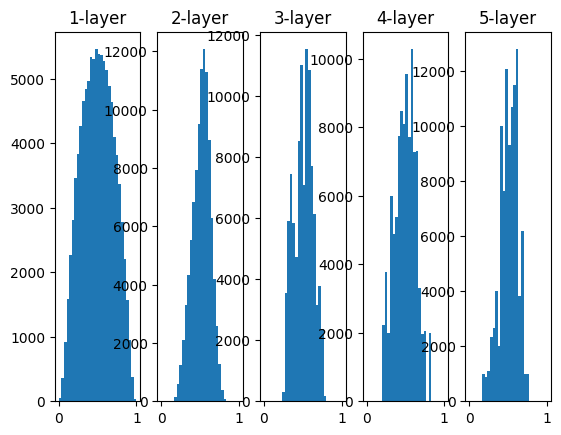

In [ ]:
#6.2.2 은닉층의 활성화값 분포

def sigmoid(x):
  return 1/(1+ np.exp(-x))

x = np.random.randn(1000, 100) #100개의 x가 1000개인 배치 데이타
node_num = 100 #한 레이어 당 노드 개수
hidden_layer_size = 5 #히든 레이어 개수
activ = {} #sigmoid 결과 저장 딕셔너리

for i in range(hidden_layer_size):

  if i != 0: #첫 실행일땐 패스함
    x = activ[i-1] # 시그모이드(xw)의 결과가 다음 레이어의 입력값이니까.

  w = np.random.randn(node_num,node_num) / np.sqrt(node_num)
  a = np.dot(x,w)
  z = sigmoid(a)
  activ[i] = z #각 히든레이어 act에 저장함

for i,a in activ.items():
  plt.subplot(1, len(activ), i+1)
  plt.title(str(i+1) + "-layer")
  plt.hist(a.flatten(),30,range=(0,1))

plt.show()# w를 1로 나눈 결과를 보면 0과 1쪽에 분포가 많이 되어있어서 기울기 손실이 빼박 일어나서 학습을 못함 why? 분산이 졸라리 커져서 z값의 범위가 너무 커져버림
#그러니까 시그모이드일땐 xavier 방법인 가중치 / np.sqrt(num)을 쓰고 ReLU일땐 He방법을 쓰자 sqrt(2/num)

#추가 설명 : 저런식으로 나눠주지 않으면 위의 경우 a의 분산이 100이됨 : 평균0 분산1 독립변수 100개를 더하면 분산이 100이됨.
#참고로 x_1w_1+x_2+w_2 형태에서 x랑 w를 곱해도 여전히 분산이 1임 왜냐? 평균0 분산 1끼리 곱했기때문에

In [ ]:
#배치정규화 학습 빨리 진행, 오버피팅 억제, 초깃값 의존성 저하
#보통 Affine-BatchNorm-Relu로 사용됨
#x^_i = x_i-μ_B/(sqrt(Var(B)+e)
#여기에는 미니배치B = [x_1 ,x_2.....x_m]의 평균 mu와 분산 Var(B)를 구함
#*이식은 단순히 미니배치 입력데이터를 μ = 0 Var = 1인 데이터로 변환함*
#이 처리를 활성화 함수 앞 or 뒤에 삽입하여 데이터 분포가 덜 치우치게 한다.

#이 정규화 된 x^를 우야라는건가
#y_i = (γ * x^_i) + beta
#여기서 알다시피 감마가 분산을 베타가 평균을 담당함 처음에 감마 = 1 베타는 0으로 시작함, 학습하면서 적당값 조정
#미분도 가능함(학습을 위해서 미분이 꼭 가능해야함) => 감마로 미분하면 x^_i, 베타로 미분하면 1

{0: 1, 1: 2}


In [ ]:
#6.4.2 가중치 감소
#걍 L2써라